# Getting started with SiReNetA

Authors: **Gorka Zamora-López** and **Matthieu Gilson**

<br/>

---------------------

This notebook is an introductory tutorial for *Stimulus-Response Network Analysis* (SRNA) to study complex networks and the use of the corresponding Python package [SiReNetA](https://github.com/mb-BCA/SiReNetA).

#### Outline
1. Installation of the *SiReNetA* library.
2. Familiarization with the library and getting information.
3. First steps into *SRNA*:
    * Pair-wise, node-wise and network level responses.
    * Network metrics from the responses.
    * Running simulations of the canonical models.



----------------
## 1. Installing the *SiReNetA* library

*SiReNetA* is built upon the array object definition of [NumPy](https://numpy.org) and it uses functions from the [SciPy](https://scipy.org) library. Running these tutorials also requires [Matplotlib](https://matplotlib.org) for plotting and visualization purposes. The installation of *SiReNetA* will check for the presence of these libraries and install them if not available.

To get started, the first thing we need is to load the libraries we will need to work. Start importing the built-in and third party libraries.

The following cell checks whether *SiReNetA* is already installed (in the same Python environment in which this notebook is running) and otherwise, the library will be installed using Python package installer [pip](https://pypi.org/project/pip/). 

>**Note**: the exclamation mark ( ! ) before `pip install galib` indicates the Jupyter notebook to run the line of code as a system command, same as if we would run it from a terminal window.

In [3]:
## Check SiReNetA is installed in the current Python environment, otherwise install
try:
    import sireneta
except:
    # Install from the GitHub repository
    print('Installing SiReNetA from GitHub ...')
    ! pip install git+https://github.com/mb-BCA/SiReNetA.git@master

# Make sure the library is properly installed by importing it
import sireneta as sna

## 2. Getting familiarised 

Information about the library, its modules and functions is found 'online' as usual. Type `help(module_name)` or `module_name?` in a cell of the notebook (or in an IPython interactive window) to access the corresponding information (docstrings).

Run the following cell to see the general overview of *SiReNetA*.

In [2]:
# See the general description of sireneta library 
sna?

As seen, the library is organised into four user modules:

- responses.py
- metrics.py
- simulate.py
- tools.py

Run the following cell (uncommenting lines one-by-one) to see the description and a list of functions accessible in each module.

In [2]:
## Explore the help functions of SiReNetA

#sna.responses?
#sna.metrics?
#sna.simulate?
#sna.tools?

Object `sna.responses` not found.


Finally, check the description of individual functions, the expected parameters and their outputs. For example:

In [4]:
#sna.responses.TransitionMatrix?
sna.responses.Resp_DiscreteCascade?
#sna.responses.Resp_LeakyCascade?
#sna.metrics.GlobalResponse?
#sna.metrics.TimeToPeak?
#sna.simulate.RandomWalk?


&nbsp;

--------
## 3. First steps into Stimulus-Response Network Analysis (SRNA)


The core idea behind *SRNA* is to reveal the properties of networks by probing how the nodes of a network respond localised perturbations. That is, to apply a stimulus of unit amplitude to one node and observe how the others respond. The manner in which the stimulus propagates throughout the network depends on the dynamical propagation dynamical model selected. Network metrics are then extracted out of the pair-wise, node-wise or global responses.

For illustration, we will load the small graph (binary and undirected) depicted below and  visualise the different types of responses.

![Sample Graph, n=8 nodes](#)



In [6]:
# Python standard library imports
# Third party imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#import numpy.linalg


In [31]:
# Load a small network (binary / unweighted)
net = np.loadtxt('Data/Testnet_N8.txt', dtype=int)
N = len(net)

print(net)

[[0 1 1 0 0 0 0 0]
 [1 0 0 1 0 1 0 0]
 [1 0 0 1 0 0 0 0]
 [0 1 1 0 1 1 0 1]
 [0 0 0 1 0 0 0 0]
 [0 1 0 1 0 0 1 1]
 [0 0 0 0 0 1 0 0]
 [0 0 0 1 0 1 0 0]]


### Discrete cascade propagation dynamics

In [9]:
# Compute the responses for the discrete cascade 
# Assume each node receives stimulus of amplitude 1 (default)

# Duration of the "simulation"
tfinal = 15
# The pair-wise responses
resps_dc = sna.Resp_DiscreteCascade(net, S0=1.0, tmax=tfinal)
print(shape(resps_dc))

(16, 8, 8)


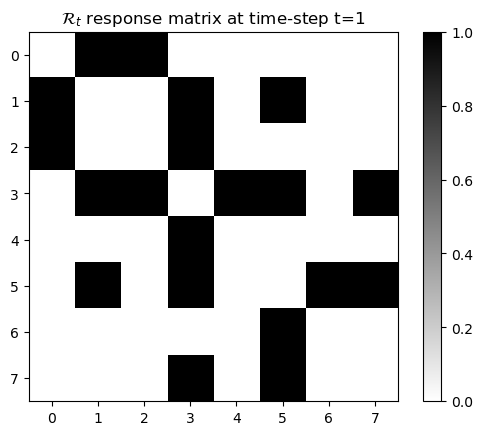

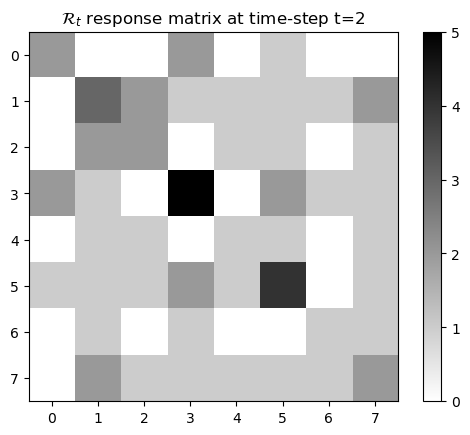

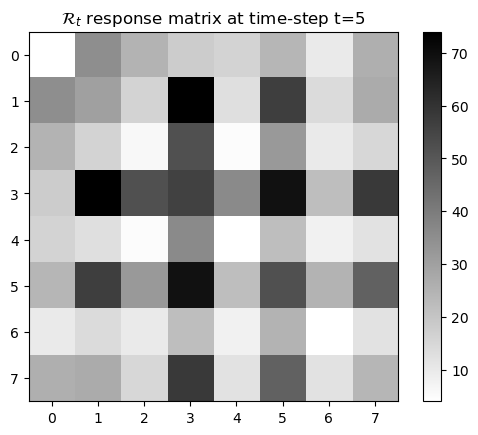

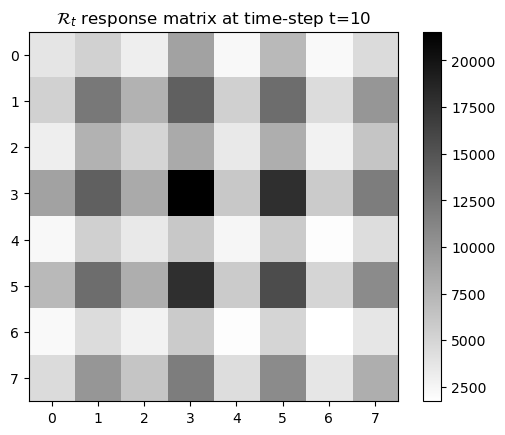

In [17]:
# Visualise the pair-wise response matrices at times t = 1, 2, 5, 10

timelist = [1,2,5,10]
for t in timelist:
    plt.figure()
    plt.title('$\mathcal{R}_t$ response matrix at time-step t=%d' %t)
    plt.imshow(resps_dc[t], cmap='gray_r')
    plt.colorbar()

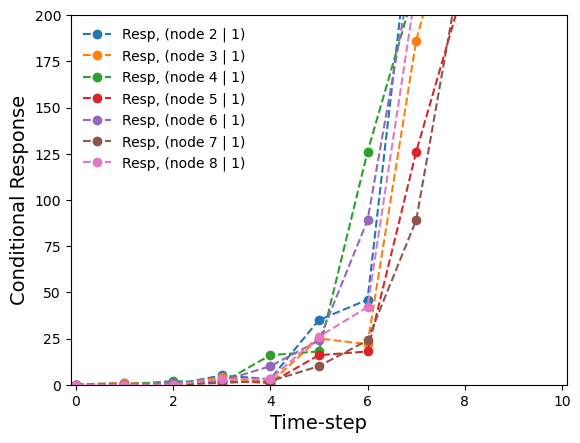

In [28]:
# Visualise temporal responses of nodes i = 2, 3, ... , 8 to stimulus in j = 1

plt.figure()
for i in range(1,8):
    plt.plot(arange(tfinal+1), resps_dc[:,0,i], 'o--', label='Resp, (node %d | 1)' %(i+1) )
plt.xlim(-0.1,10.1)
plt.ylim(0,200)
plt.xlabel('Time-step')
plt.ylabel('Conditional Response')
plt.legend(frameon=False)


<br/>

### Continuous leaky-cascade propagation model

Given that $A$ is the connectivity matrix (weighted or unweighted, directed or undirected) the dynamics of a node follows: 

$ \dot{x}_i = - \frac{x_i}{\tau} + \sum_{j=1}^N x_j $

where $\tau$ is the leakage time-constant. The role of $\tau$ is to control the rate of leakage through the nodes, thus counter-balancing the tendency of the linear connectivity to cause the divergence of the system.

The pair-wise responses $R_{ij}(t)$ qunatify the effect of a stimulus on (source) node $i$, applied at $t=0$, has on (target) node $j$ at time $t$.

<!-- Thus, dynamic communicability quantifies the network response to a unit stimulus (via the Green function). The following examples will emphasize a few basic properties: 

- Dynamic communicability captures the evolution of the global network feedback over (integration) time.
- Node-wise input and output communicabilities capture the listening and broadcasting nature of nodes.
- Two nodes without a direct connection use to have non-zero interactions due to the network effects.
- Along integration time the dynamic communicability matrix is first dominated by node weights, then by network feedback and finally it becomes homogeneous.

-->

In [33]:
# Find the spectral radius and the largest time constant 
evs = numpy.linalg.eigvals(net)
evsnorms = np.zeros(N, float)
for i in range(N):
    evsnorms[i] = numpy.linalg.norm(evs[i])
evmax = evsnorms.max()
taumax = 1./evmax

print( 'Spectral radius:\t%2.5f' %evmax )
print( 'Largest possible tau:\t%2.5f' %taumax )

Spectral radius:	3.03407
Largest possible tau:	0.32959


In [68]:
# Set a leakage time-constant
tau = 0.8 * taumax

# Define the temporal resolution for the "simulation"
tfinal = 10
dt = 0.01
tpoints = np.arange(0.0, tfinal+dt, dt)
nsteps = len(tpoints)

# Calculate the pair-wise responses for a time span between 0 and tmax
resps_lc = sna.Resp_LeakyCascade(net, S0=1.0, tau=tau, tmax=tfinal, timestep=dt) 

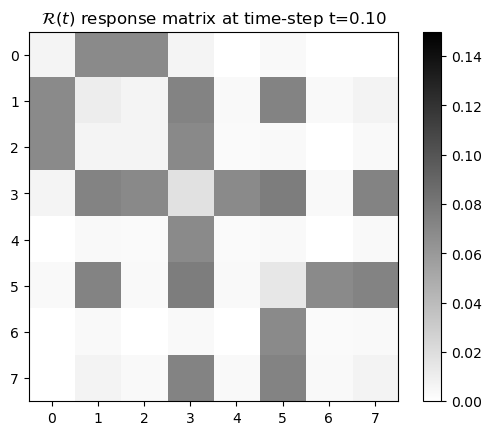

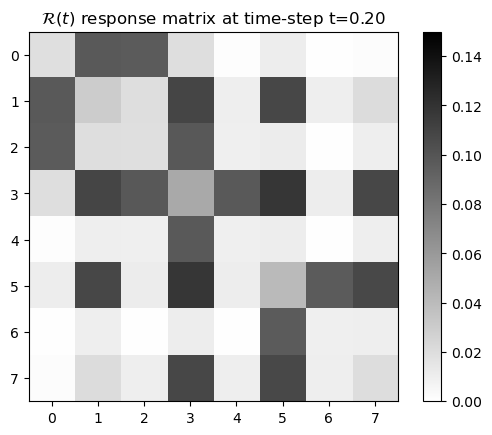

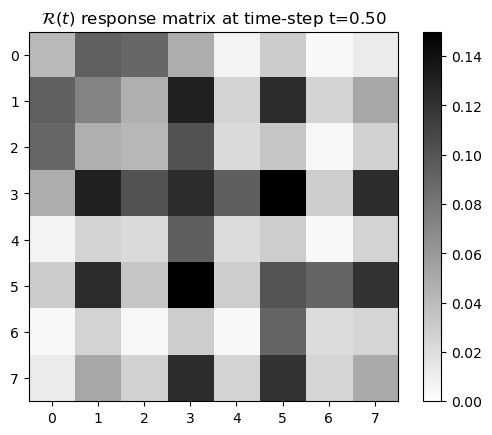

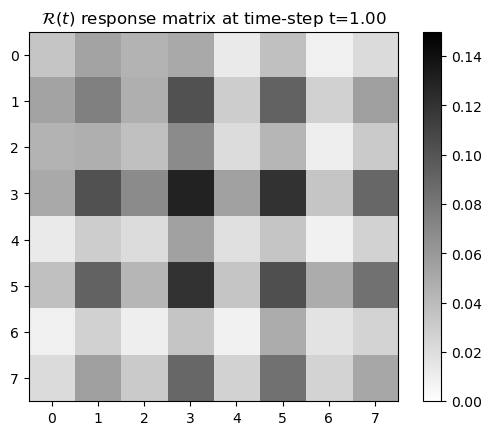

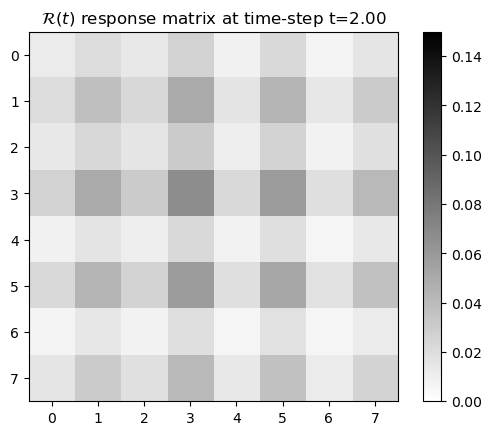

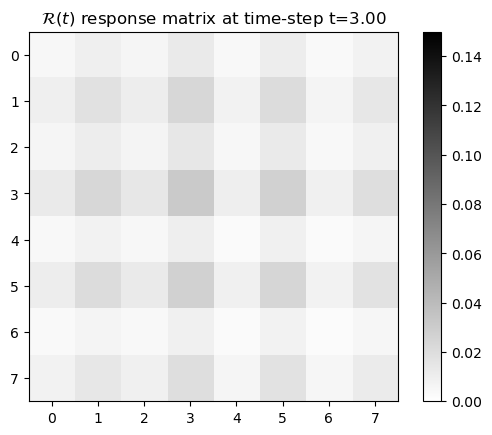

In [40]:
# Visualise the pair-wise response matrices at times t = 0.1, 0.3, 0.5, 1.0, 2.0, 3.0
maxresp = resps_lc.max()

tidxlist = [10,20,50,100,200,300]
for tidx in tidxlist:
    t = tpoints[tidx]
    plt.figure()
    plt.title('$\mathcal{R}(t)$ response matrix at time-step t=%1.2f' %t)
    plt.imshow(resps_lc[tidx], cmap='gray_r')
    plt.clim(0,maxresp)
    plt.colorbar()

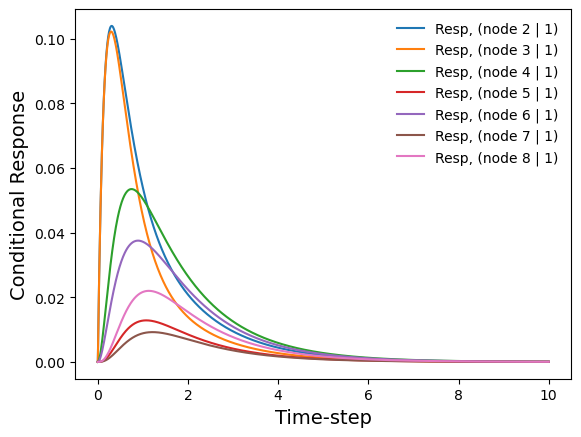

In [43]:
# Visualise temporal responses of nodes i = 2, 3, ... , 8 to stimulus in j = 1

plt.figure()
for i in range(1,8):
    plt.plot(tpoints, resps_lc[:,0,i], label='Resp, (node %d | 1)' %(i+1) )
plt.xlabel('Time-step')
plt.ylabel('Conditional Response')
plt.legend(frameon=False)


Comments here.

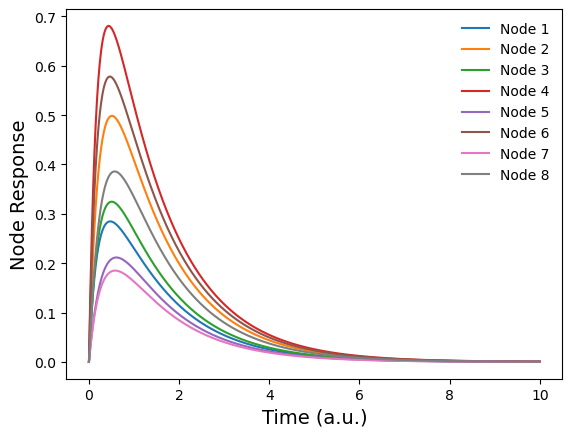

In [52]:
# Compute and visualise the node responses
inresp, outresp = sna.NodeResponses(resps_lc, selfloops=False)

plt.figure()
for i in range(N):
    plt.plot(tpoints,inresp[:,i], label='Node %d' %(i+1))
plt.xlabel('Time (a.u.)')
plt.ylabel('Node Response')
plt.legend(frameon=False)

Text(0.5, 0, 'Node index')

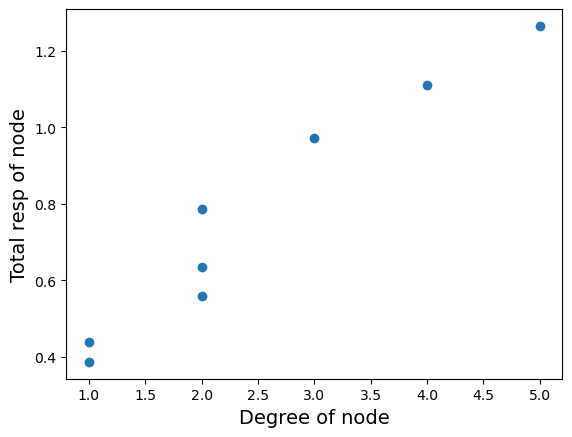

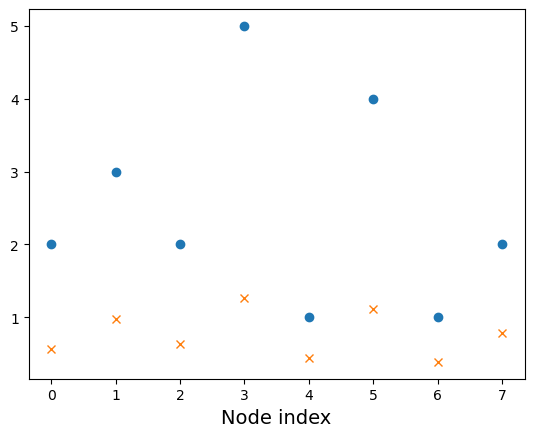

In [56]:
# Compare the node response with the degree
deg = net.sum(axis=0)

noderesp = sna.AreaUnderCurve(inresp, timestep=dt)

plt.figure()
plt.plot(deg,noderesp, 'o')
plt.xlabel('Degree of node')
plt.ylabel('Total resp of node')

plt.figure()
plt.plot(deg, 'o', label='Degree of node')
plt.plot(noderesp, 'x', label='Response of node')
plt.xlabel('Node index')

Text(0, 0.5, 'Global net resp')

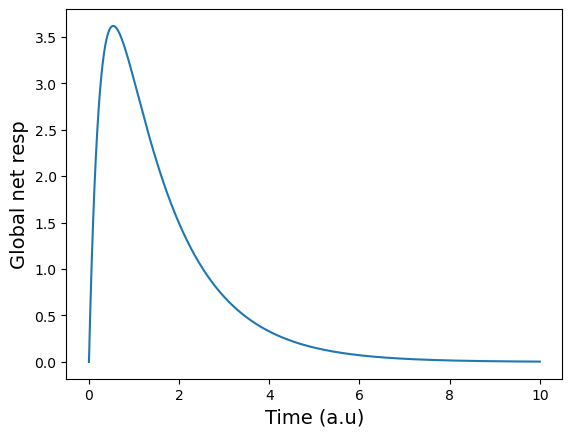

In [70]:
# Compute and visulise the global network response
netresp = sna.GlobalResponse(resps_lc)

plt.figure()
plt.plot(tpoints,netresp)
plt.xlabel('Time (a.u)')
plt.ylabel('Global net resp')


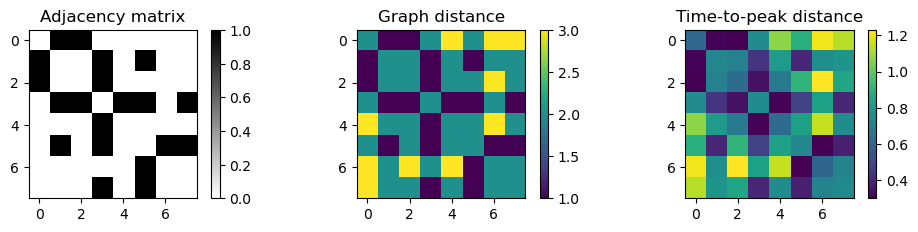

In [69]:
# Compute the classical graph distance
import galib
dij = galib.FloydWarshall(net)

# Compute the time-to-peak distance
ttpdist = sna.Time2Peak(resps_lc, timestep=dt)

plt.figure(figsize=(10,2.4))
# Plot the adjacency matrix
plt.subplot(1,3,1)
plt.title('Adjacency matrix')
plt.imshow(net, cmap='gray_r')
plt.colorbar()

# Plot the classical graph distance
plt.subplot(1,3,2)
plt.title('Graph distance')
plt.imshow(dij)
plt.colorbar()

# Plot the time-2-peak distance matrix
plt.subplot(1,3,3)
plt.title('Time-to-peak distance')
plt.imshow(ttpdist)
plt.colorbar()

plt.tight_layout()

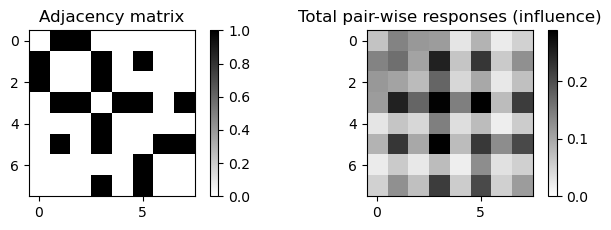

In [77]:
# Visualise the total link-wise responses
pw_resps = sna.AreaUnderCurve(resps_lc, timestep=dt)

plt.figure(figsize=(7,2.4))
plt.subplot(1,2,1)
plt.title('Adjacency matrix')
plt.imshow(net, cmap='gray_r')
plt.colorbar()

plt.subplot(1,2,2)
plt.title('Total pair-wise responses (influence)')
plt.imshow(pw_resps, cmap='gray_r', vmin=0)
plt.colorbar()

plt.tight_layout()

For a given network represented by $A$, the tendency of the network dynamics to diverge is represented by the largest eigenvalue (spectral radious) $\lambda_{max}$ of $A$. To assure the convergence of the system the leakage along each node needs to counterbalance this tendency. For that, the condicion $\tau < \tau_{max}$ with $\tau_{max} = 1 \,/\, \lambda_{max}$ needs to be fulfilled. 
In this particular case, all the eigenvalues of the directed path graph are zero, thus, $\tau_{max} = \infty$ and the system converges for any value of $\tau$. But this will not be the case in general.

We now define an _**external perturbation**_, which is encoded in the `stimvec` array, containing the amplitude on the initial stimuli at each node. In this case, we assume an stimulus of unit amplitude, only at the first node.